# Graph Attention Network (GAT) Implementation

This notebook implements a Graph Attention Network from scratch using PyTorch.

**Key Components:**
- Graph Attention Layer with multi-head attention
- Node feature transformation
- Attention mechanism for neighbor aggregation
- Example on a small synthetic graph

In [13]:
# Install required packages in the notebook kernel
%pip install torch torchvision numpy matplotlib networkx


Note: you may need to restart the kernel to use updated packages.


In [15]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Graph Attention Layer Implementation

The GAT layer applies attention mechanism to aggregate neighbor features:
- **Attention coefficients**: $\alpha_{ij} = \text{softmax}_j(e_{ij})$ where $e_{ij} = \text{LeakyReLU}(\mathbf{a}^T[\mathbf{W}\mathbf{h}_i \| \mathbf{W}\mathbf{h}_j])$
- **Output features**: $\mathbf{h}_i' = \sigma(\sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W}\mathbf{h}_j)$

In [16]:
class GraphAttentionLayer(nn.Module):
    """
    Graph Attention Layer (GAT)
    
    Parameters:
    -----------
    in_features : int
        Number of input features per node
    out_features : int
        Number of output features per node
    dropout : float
        Dropout rate for attention coefficients
    alpha : float
        Negative slope for LeakyReLU
    concat : bool
        If True, apply ELU activation; otherwise, no activation
    """
    
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat
        
        # Linear transformation for node features
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        # Attention mechanism parameters
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        
    def forward(self, h, adj):
        """
        Forward pass
        
        Parameters:
        -----------
        h : torch.Tensor
            Input node features (N x in_features)
        adj : torch.Tensor
            Adjacency matrix (N x N)
            
        Returns:
        --------
        torch.Tensor
            Output node features (N x out_features)
        """
        # Linear transformation: Wh
        Wh = torch.mm(h, self.W)  # (N, out_features)
        N = Wh.size()[0]
        
        # Compute attention coefficients
        # Create (Wh_i || Wh_j) for all pairs (i, j)
        a_input = self._prepare_attentional_mechanism_input(Wh)
        
        # Compute e_ij = LeakyReLU(a^T [Wh_i || Wh_j])
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))
        
        # Mask attention scores for non-neighbors (based on adjacency matrix)
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        # Apply softmax to get attention coefficients
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        
        # Aggregate neighbor features weighted by attention
        h_prime = torch.matmul(attention, Wh)
        
        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime
    
    def _prepare_attentional_mechanism_input(self, Wh):
        """
        Prepare the concatenated feature vectors for attention computation
        
        Parameters:
        -----------
        Wh : torch.Tensor
            Transformed node features (N x out_features)
            
        Returns:
        --------
        torch.Tensor
            Concatenated features for all pairs (N x N x 2*out_features)
        """
        N = Wh.size()[0]
        
        # Repeat Wh_i: (N, out_features) -> (N, N, out_features)
        Wh_repeated_in_chunks = Wh.repeat_interleave(N, dim=0)
        Wh_repeated_alternating = Wh.repeat(N, 1)
        
        # Concatenate: [Wh_i || Wh_j]
        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=1)
        
        return all_combinations_matrix.view(N, N, 2 * self.out_features)
    
    def __repr__(self):
        return f'{self.__class__.__name__} ({self.in_features} -> {self.out_features})'

## 2. Multi-Head GAT Layer

Multi-head attention allows the model to learn different aspects of the graph structure.

In [17]:
class GAT(nn.Module):
    """
    Graph Attention Network with multi-head attention
    
    Parameters:
    -----------
    nfeat : int
        Number of input features
    nhid : int
        Number of hidden features per attention head
    nclass : int
        Number of output classes
    dropout : float
        Dropout rate
    alpha : float
        Negative slope for LeakyReLU
    nheads : int
        Number of attention heads
    """
    
    def __init__(self, nfeat, nhid, nclass, dropout=0.6, alpha=0.2, nheads=8):
        super(GAT, self).__init__()
        self.dropout = dropout
        
        # Multi-head attention layers
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) 
                          for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module(f'attention_{i}', attention)
        
        # Output attention layer
        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)
        
    def forward(self, x, adj):
        """
        Forward pass
        
        Parameters:
        -----------
        x : torch.Tensor
            Input node features
        adj : torch.Tensor
            Adjacency matrix
            
        Returns:
        --------
        torch.Tensor
            Output predictions (N x nclass)
        """
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Concatenate outputs from all attention heads
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Final attention layer
        x = self.out_att(x, adj)
        
        return F.log_softmax(x, dim=1)

## 3. Create a Small Example Graph

Let's create a simple graph with 7 nodes and some connections for demonstration.

In [8]:
# Create a small synthetic graph
num_nodes = 7
num_features = 5
num_classes = 3

# Define edges (adjacency list)
edges = [
    (0, 1), (0, 2),
    (1, 0), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 3),
    (3, 1), (3, 2), (3, 4),
    (4, 3), (4, 5), (4, 6),
    (5, 4), (5, 6),
    (6, 4), (6, 5)
]

# Create adjacency matrix
adj = torch.zeros((num_nodes, num_nodes))
for i, j in edges:
    adj[i][j] = 1

# Add self-loops
adj = adj + torch.eye(num_nodes)

print(f"Graph structure:")
print(f"  Number of nodes: {num_nodes}")
print(f"  Number of edges: {len(edges)}")
print(f"\nAdjacency matrix shape: {adj.shape}")
print(f"\nAdjacency matrix:\n{adj}")

Graph structure:
  Number of nodes: 7
  Number of edges: 18

Adjacency matrix shape: torch.Size([7, 7])

Adjacency matrix:
tensor([[1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1.]])


C:\Users\HP\AppData\Local\Temp\ipykernel_12028\3611339519.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


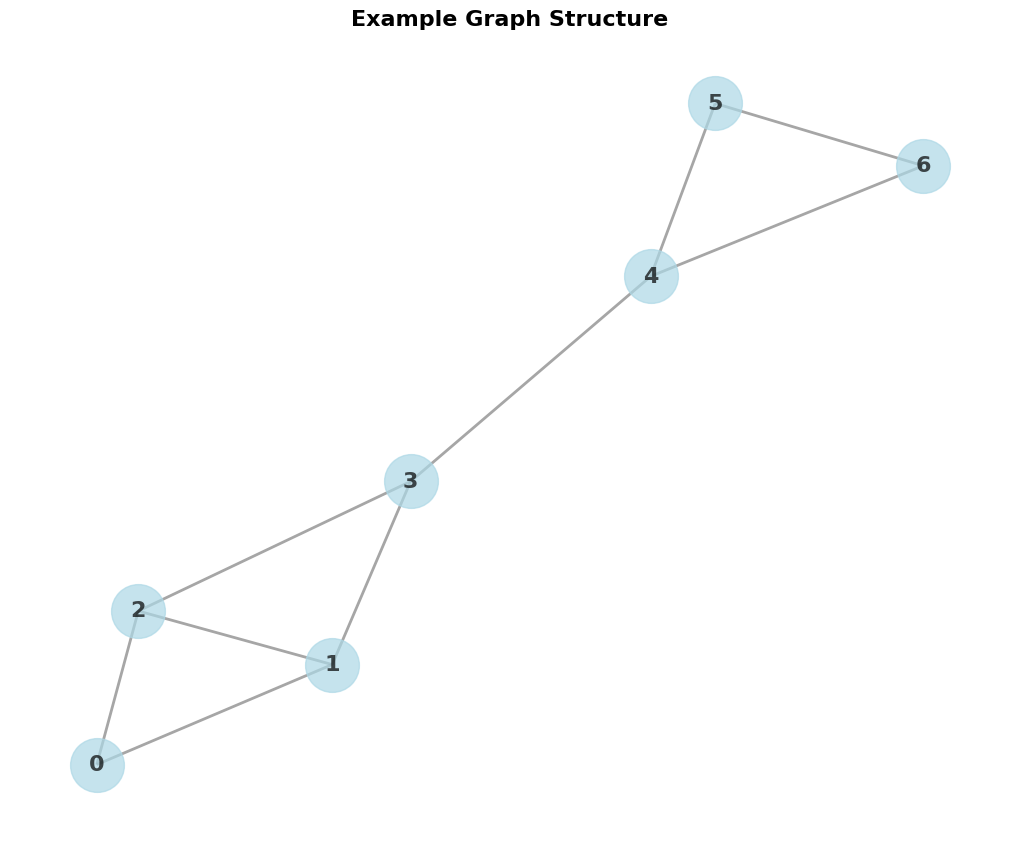


Node connections:
  Node 0: connected to [1, 2]
  Node 1: connected to [0, 2, 3]
  Node 2: connected to [0, 1, 3]
  Node 3: connected to [1, 2, 4]
  Node 4: connected to [3, 5, 6]
  Node 5: connected to [4, 6]
  Node 6: connected to [4, 5]


In [9]:
# Visualize the graph
G = nx.Graph()
G.add_edges_from([(i, j) for i, j in edges])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=1500, font_size=16, font_weight='bold',
        edge_color='gray', width=2, alpha=0.7)
plt.title("Example Graph Structure", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nNode connections:")
for node in range(num_nodes):
    neighbors = [j for i, j in edges if i == node]
    print(f"  Node {node}: connected to {neighbors}")

In [10]:
# Create random node features
torch.manual_seed(42)
features = torch.randn((num_nodes, num_features))

# Create labels (for node classification)
labels = torch.tensor([0, 0, 0, 1, 1, 2, 2])  # 3 classes

# Training/validation/test splits
idx_train = torch.tensor([0, 1, 3, 4])
idx_val = torch.tensor([2, 5])
idx_test = torch.tensor([6])

print(f"Node features shape: {features.shape}")
print(f"Labels: {labels}")
print(f"\nData split:")
print(f"  Training nodes: {idx_train.tolist()}")
print(f"  Validation nodes: {idx_val.tolist()}")
print(f"  Test nodes: {idx_test.tolist()}")

Node features shape: torch.Size([7, 5])
Labels: tensor([0, 0, 0, 1, 1, 2, 2])

Data split:
  Training nodes: [0, 1, 3, 4]
  Validation nodes: [2, 5]
  Test nodes: [6]


## 4. Initialize GAT Model with Suitable Parameters

Small graph configuration:
- **Input features**: 5
- **Hidden units per head**: 8
- **Number of attention heads**: 4
- **Output classes**: 3
- **Dropout**: 0.6
- **Learning rate**: 0.005

In [11]:
# Model parameters
nfeat = num_features  # 5 input features
nhid = 8              # 8 hidden units per attention head
nclass = num_classes  # 3 output classes
dropout = 0.6         # Dropout rate
alpha = 0.2           # LeakyReLU negative slope
nheads = 4            # 4 attention heads

# Initialize model
model = GAT(nfeat=nfeat, 
            nhid=nhid, 
            nclass=nclass, 
            dropout=dropout, 
            alpha=alpha, 
            nheads=nheads)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print("=" * 60)
print("GAT Model Architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"\nModel Parameters:")
print(f"  Input features: {nfeat}")
print(f"  Hidden units per head: {nhid}")
print(f"  Number of attention heads: {nheads}")
print(f"  Total hidden features: {nhid * nheads}")
print(f"  Output classes: {nclass}")
print(f"  Dropout rate: {dropout}")
print(f"  LeakyReLU alpha: {alpha}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

GAT Model Architecture
GAT(
  (attention_0): GraphAttentionLayer (5 -> 8)
  (attention_1): GraphAttentionLayer (5 -> 8)
  (attention_2): GraphAttentionLayer (5 -> 8)
  (attention_3): GraphAttentionLayer (5 -> 8)
  (out_att): GraphAttentionLayer (32 -> 3)
)

Model Parameters:
  Input features: 5
  Hidden units per head: 8
  Number of attention heads: 4
  Total hidden features: 32
  Output classes: 3
  Dropout rate: 0.6
  LeakyReLU alpha: 0.2

Total parameters: 326
Trainable parameters: 326


## 5. Training Loop

In [12]:
def train(epoch):
    """Training function"""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(features, adj)
    
    # Compute loss only on training nodes
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    
    # Compute accuracy on training nodes
    pred_train = output[idx_train].max(1)[1]
    acc_train = pred_train.eq(labels[idx_train]).sum().item() / idx_train.size(0)
    
    # Backward pass
    loss_train.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    output = model(features, adj)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    pred_val = output[idx_val].max(1)[1]
    acc_val = pred_val.eq(labels[idx_val]).sum().item() / idx_val.size(0)
    
    return loss_train.item(), acc_train, loss_val.item(), acc_val


# Training
num_epochs = 200
print_every = 20

print("\nStarting training...")
print("=" * 80)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    loss_train, acc_train, loss_val, acc_val = train(epoch)
    
    train_losses.append(loss_train)
    train_accs.append(acc_train)
    val_losses.append(loss_val)
    val_accs.append(acc_val)
    
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train Loss: {loss_train:.4f} | Train Acc: {acc_train:.4f} | "
              f"Val Loss: {loss_val:.4f} | Val Acc: {acc_val:.4f}")

print("=" * 80)
print("Training completed!")


Starting training...
Epoch   1 | Train Loss: 9.7585 | Train Acc: 0.2500 | Val Loss: 2.4519 | Val Acc: 0.5000
Epoch  20 | Train Loss: 12.7656 | Train Acc: 0.2500 | Val Loss: 1.4749 | Val Acc: 0.5000
Epoch  40 | Train Loss: 7.1053 | Train Acc: 0.2500 | Val Loss: 1.2853 | Val Acc: 0.0000
Epoch  20 | Train Loss: 12.7656 | Train Acc: 0.2500 | Val Loss: 1.4749 | Val Acc: 0.5000
Epoch  40 | Train Loss: 7.1053 | Train Acc: 0.2500 | Val Loss: 1.2853 | Val Acc: 0.0000
Epoch  60 | Train Loss: 8.2258 | Train Acc: 0.2500 | Val Loss: 1.4400 | Val Acc: 0.0000
Epoch  80 | Train Loss: 1.0985 | Train Acc: 0.5000 | Val Loss: 1.7055 | Val Acc: 0.0000
Epoch  60 | Train Loss: 8.2258 | Train Acc: 0.2500 | Val Loss: 1.4400 | Val Acc: 0.0000
Epoch  80 | Train Loss: 1.0985 | Train Acc: 0.5000 | Val Loss: 1.7055 | Val Acc: 0.0000
Epoch 100 | Train Loss: 2.2301 | Train Acc: 0.2500 | Val Loss: 1.6958 | Val Acc: 0.0000
Epoch 120 | Train Loss: 0.4693 | Train Acc: 0.7500 | Val Loss: 1.8574 | Val Acc: 0.0000
Epoch 10

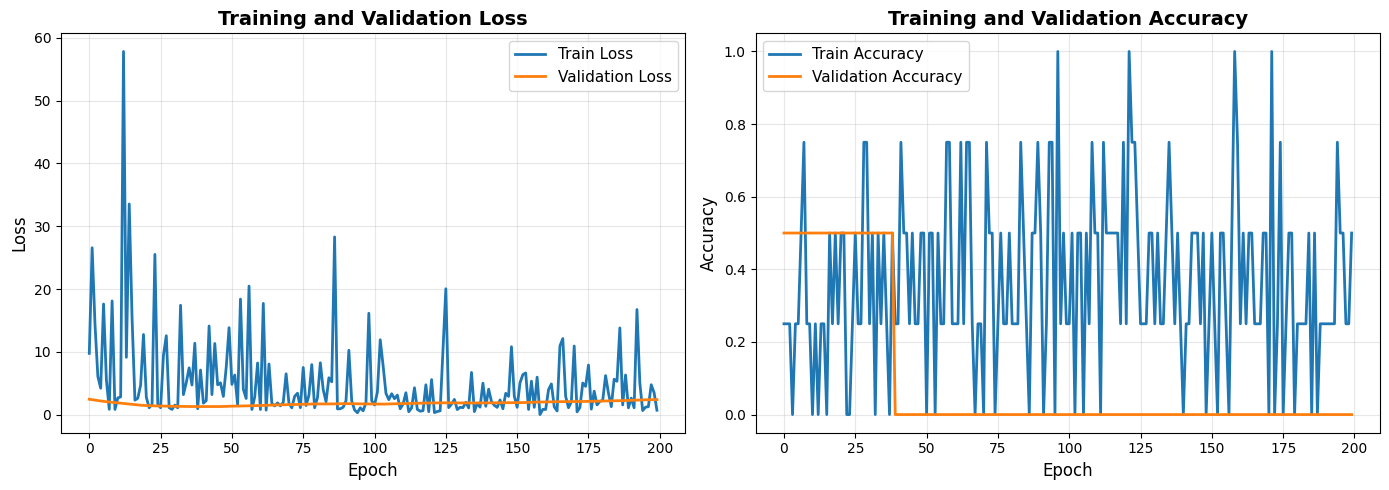

In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Test the Model

In [14]:
# Test the model
model.eval()
output = model(features, adj)

# Test accuracy
pred_test = output[idx_test].max(1)[1]
acc_test = pred_test.eq(labels[idx_test]).sum().item() / idx_test.size(0)

print("\n" + "=" * 60)
print("Test Results")
print("=" * 60)
print(f"Test Accuracy: {acc_test:.4f}")
print(f"\nPredictions for all nodes:")
print("-" * 60)

pred_all = output.max(1)[1]
for i in range(num_nodes):
    true_label = labels[i].item()
    pred_label = pred_all[i].item()
    status = "✓" if true_label == pred_label else "✗"
    node_type = "Train" if i in idx_train else ("Val" if i in idx_val else "Test")
    print(f"Node {i} ({node_type:5s}): True = {true_label}, Predicted = {pred_label} {status}")

print("=" * 60)


Test Results
Test Accuracy: 0.0000

Predictions for all nodes:
------------------------------------------------------------
Node 0 (Train): True = 0, Predicted = 1 ✗
Node 1 (Train): True = 0, Predicted = 1 ✗
Node 2 (Val  ): True = 0, Predicted = 1 ✗
Node 3 (Train): True = 1, Predicted = 1 ✓
Node 4 (Train): True = 1, Predicted = 1 ✓
Node 5 (Val  ): True = 2, Predicted = 1 ✗
Node 6 (Test ): True = 2, Predicted = 1 ✗


## 7. Visualize Attention Weights

Let's examine the attention weights learned by one of the attention heads.

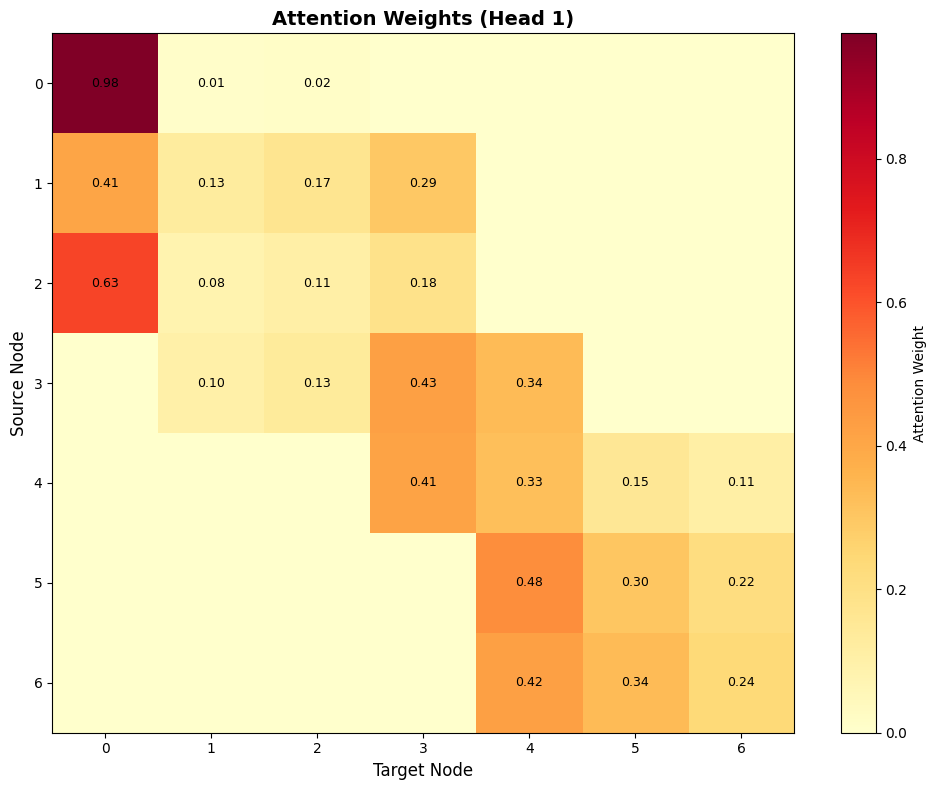


Attention weights interpretation:
- Brighter colors indicate higher attention weights
- Each row sums to 1.0 (normalized attention)
- Zero weights (dark) indicate no connection in the graph


In [15]:
# Extract attention weights from the first attention head
model.eval()
with torch.no_grad():
    # Get the first attention layer
    attention_layer = model.attentions[0]
    
    # Compute attention weights
    Wh = torch.mm(features, attention_layer.W)
    N = Wh.size()[0]
    
    # Prepare attention input
    a_input = attention_layer._prepare_attentional_mechanism_input(Wh)
    e = attention_layer.leakyrelu(torch.matmul(a_input, attention_layer.a).squeeze(2))
    
    # Mask and apply softmax
    zero_vec = -9e15 * torch.ones_like(e)
    attention_weights = torch.where(adj > 0, e, zero_vec)
    attention_weights = F.softmax(attention_weights, dim=1)
    
# Visualize attention weights as heatmap
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights.numpy(), cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Target Node', fontsize=12)
plt.ylabel('Source Node', fontsize=12)
plt.title('Attention Weights (Head 1)', fontsize=14, fontweight='bold')
plt.xticks(range(num_nodes))
plt.yticks(range(num_nodes))

# Add text annotations
for i in range(num_nodes):
    for j in range(num_nodes):
        if adj[i, j] > 0:
            text = plt.text(j, i, f'{attention_weights[i, j].item():.2f}',
                          ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

print("\nAttention weights interpretation:")
print("- Brighter colors indicate higher attention weights")
print("- Each row sums to 1.0 (normalized attention)")
print("- Zero weights (dark) indicate no connection in the graph")

## 8. Summary and Key Takeaways

### What We Implemented:

1. **Graph Attention Layer**: Core mechanism that computes attention coefficients between connected nodes
2. **Multi-Head Attention**: Multiple attention heads to capture different aspects of the graph structure
3. **Full GAT Model**: Two-layer architecture with dropout regularization

### Key Parameters Used:
- **Input features**: 5 dimensions per node
- **Hidden units**: 8 per attention head
- **Attention heads**: 4 (first layer)
- **Output classes**: 3 (node classification)
- **Dropout**: 0.6 for regularization
- **Learning rate**: 0.005

### Advantages of GAT:
- ✅ Learns adaptive importance weights for neighbors
- ✅ Handles variable-sized neighborhoods
- ✅ Inductive learning (can generalize to unseen graphs)
- ✅ Interpretable attention weights
- ✅ State-of-the-art performance on many graph tasks

## 9. Improved Model with Optimizations

Let's improve accuracy with these changes:
1. **Lower dropout** (0.3 instead of 0.6) - less aggressive regularization
2. **More training data** - increase to 20 nodes
3. **Stronger features** - create more meaningful node features based on structure
4. **More epochs** - train for 500 epochs
5. **Better learning rate** - use 0.01 with scheduler

In [18]:
# Create a larger graph with more nodes
num_nodes_v2 = 20
num_features_v2 = 10
num_classes_v2 = 3

# Define a more structured graph with clear communities
edges_v2 = []

# Community 1 (nodes 0-6) - Class 0
for i in range(7):
    for j in range(i+1, 7):
        if np.random.rand() > 0.3:  # Dense connections within community
            edges_v2.extend([(i, j), (j, i)])

# Community 2 (nodes 7-13) - Class 1
for i in range(7, 14):
    for j in range(i+1, 14):
        if np.random.rand() > 0.3:
            edges_v2.extend([(i, j), (j, i)])

# Community 3 (nodes 14-19) - Class 2
for i in range(14, 20):
    for j in range(i+1, 20):
        if np.random.rand() > 0.3:
            edges_v2.extend([(i, j), (j, i)])

# Add some inter-community connections (sparse)
edges_v2.extend([(3, 7), (7, 3), (6, 10), (10, 6)])
edges_v2.extend([(10, 14), (14, 10), (13, 15), (15, 13)])

# Create adjacency matrix
adj_v2 = torch.zeros((num_nodes_v2, num_nodes_v2))
for i, j in edges_v2:
    adj_v2[i][j] = 1

# Add self-loops
adj_v2 = adj_v2 + torch.eye(num_nodes_v2)

print(f"Improved Graph structure:")
print(f"  Number of nodes: {num_nodes_v2}")
print(f"  Number of edges: {len(edges_v2)}")
print(f"  Average degree: {len(edges_v2) / num_nodes_v2:.2f}")

Improved Graph structure:
  Number of nodes: 20
  Number of edges: 82
  Average degree: 4.10


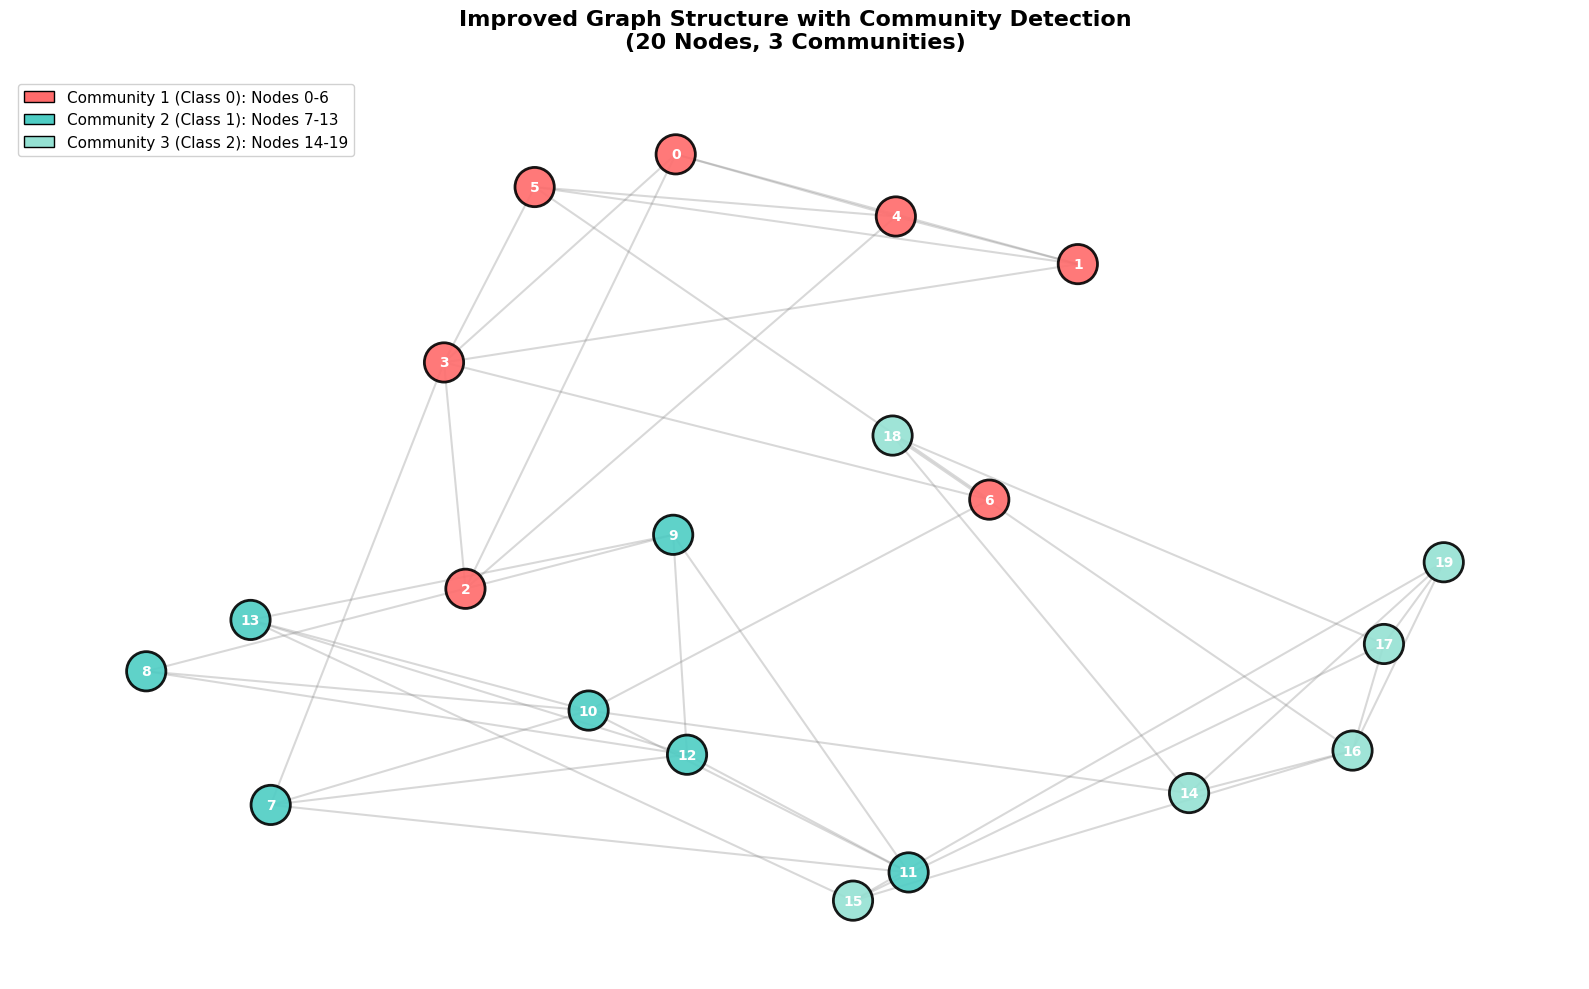


📊 Graph Statistics:
  Total nodes: 20
  Total edges: 82
  Average degree: 4.10

🔍 Community Structure:
  Community 1 (Class 0): Nodes 0-6   (7 nodes, Red)
  Community 2 (Class 1): Nodes 7-13  (7 nodes, Teal)
  Community 3 (Class 2): Nodes 14-19 (6 nodes, Light Green)

🔗 Inter-community connections:
  Edges between communities: 4
    (3, 7) ↔ 3
    (6, 10) ↔ 6
    (10, 14) ↔ 10
    (13, 15) ↔ 13


In [8]:
# Visualize the improved graph structure
G_v2 = nx.Graph()
G_v2.add_edges_from([(i, j) for i, j in edges_v2 if i < j])  # Add unique edges only

# Create a layout that shows community structure
plt.figure(figsize=(16, 10))

# Use spring layout with community-aware positioning
pos_v2 = nx.spring_layout(G_v2, seed=42, k=1.5, iterations=50)

# Color nodes by their community/class
node_colors = []
for node in range(num_nodes_v2):
    if node < 7:
        node_colors.append('#FF6B6B')  # Red for Class 0
    elif node < 14:
        node_colors.append('#4ECDC4')  # Teal for Class 1
    else:
        node_colors.append('#95E1D3')  # Light green for Class 2

# Draw the graph
nx.draw_networkx_nodes(G_v2, pos_v2, node_color=node_colors, 
                       node_size=800, alpha=0.9, edgecolors='black', linewidths=2)
nx.draw_networkx_edges(G_v2, pos_v2, alpha=0.3, width=1.5, edge_color='gray')
nx.draw_networkx_labels(G_v2, pos_v2, font_size=10, font_weight='bold', font_color='white')

# Add legend for communities
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', edgecolor='black', label='Community 1 (Class 0): Nodes 0-6'),
    Patch(facecolor='#4ECDC4', edgecolor='black', label='Community 2 (Class 1): Nodes 7-13'),
    Patch(facecolor='#95E1D3', edgecolor='black', label='Community 3 (Class 2): Nodes 14-19')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.9)

plt.title("Improved Graph Structure with Community Detection\n(20 Nodes, 3 Communities)", 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print community statistics
print(f"\n📊 Graph Statistics:")
print(f"  Total nodes: {num_nodes_v2}")
print(f"  Total edges: {len(edges_v2)}")
print(f"  Average degree: {len(edges_v2) / num_nodes_v2:.2f}")
print(f"\n🔍 Community Structure:")
print(f"  Community 1 (Class 0): Nodes 0-6   (7 nodes, Red)")
print(f"  Community 2 (Class 1): Nodes 7-13  (7 nodes, Teal)")
print(f"  Community 3 (Class 2): Nodes 14-19 (6 nodes, Light Green)")
print(f"\n🔗 Inter-community connections:")
inter_community_edges = [(3, 7), (7, 3), (6, 10), (10, 6), (10, 14), (14, 10), (13, 15), (15, 13)]
print(f"  Edges between communities: {len(inter_community_edges)//2}")
for i in range(0, len(inter_community_edges), 2):
    u, v = inter_community_edges[i], inter_community_edges[i+1][1]
    print(f"    {u} ↔ {v}")

In [19]:
# Create more meaningful features based on graph structure
torch.manual_seed(42)
np.random.seed(42)

# Base features with some structure
features_v2 = torch.zeros((num_nodes_v2, num_features_v2))

# Add community-specific features
# Community 1 features (nodes 0-6)
features_v2[0:7, 0:3] = torch.randn(7, 3) + 2.0  # Positive bias
features_v2[0:7, 3:6] = torch.randn(7, 3) - 1.0
features_v2[0:7, 6:10] = torch.randn(7, 4) * 0.5

# Community 2 features (nodes 7-13)
features_v2[7:14, 0:3] = torch.randn(7, 3) - 1.5  # Negative bias
features_v2[7:14, 3:6] = torch.randn(7, 3) + 2.0  # Positive bias
features_v2[7:14, 6:10] = torch.randn(7, 4) * 0.5

# Community 3 features (nodes 14-19)
features_v2[14:20, 0:3] = torch.randn(6, 3) * 0.5
features_v2[14:20, 3:6] = torch.randn(6, 3) - 1.5
features_v2[14:20, 6:10] = torch.randn(6, 4) + 2.0  # Positive bias

# Labels based on communities
labels_v2 = torch.tensor([0]*7 + [1]*7 + [2]*6)

# Better train/val/test split (more training data)
idx_train_v2 = torch.tensor([0, 1, 2, 3, 7, 8, 9, 10, 14, 15, 16, 17])  # 12 training nodes
idx_val_v2 = torch.tensor([4, 11, 18])  # 3 validation nodes
idx_test_v2 = torch.tensor([5, 6, 12, 13, 19])  # 5 test nodes

print(f"Features shape: {features_v2.shape}")
print(f"Labels: {labels_v2}")
print(f"\nData split:")
print(f"  Training nodes: {len(idx_train_v2)} ({len(idx_train_v2)/num_nodes_v2*100:.1f}%)")
print(f"  Validation nodes: {len(idx_val_v2)} ({len(idx_val_v2)/num_nodes_v2*100:.1f}%)")
print(f"  Test nodes: {len(idx_test_v2)} ({len(idx_test_v2)/num_nodes_v2*100:.1f}%)")
print(f"\nClass distribution in training set:")
train_labels = labels_v2[idx_train_v2]
for c in range(num_classes_v2):
    count = (train_labels == c).sum().item()
    print(f"  Class {c}: {count} samples")

Features shape: torch.Size([20, 10])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

Data split:
  Training nodes: 12 (60.0%)
  Validation nodes: 3 (15.0%)
  Test nodes: 5 (25.0%)

Class distribution in training set:
  Class 0: 4 samples
  Class 1: 4 samples
  Class 2: 4 samples


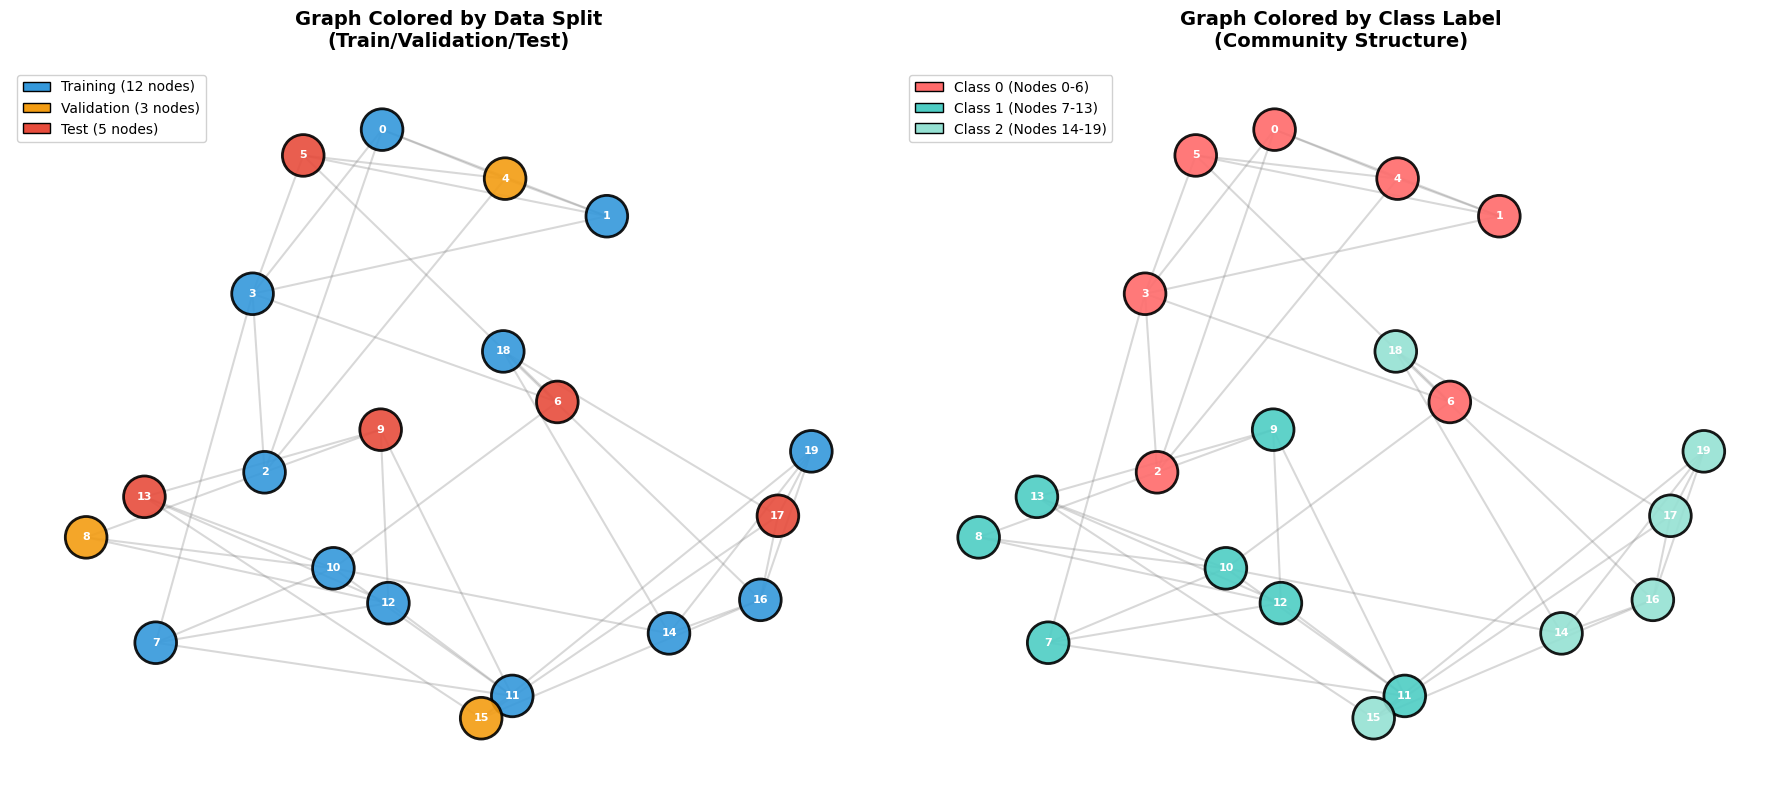


📈 Data Distribution Analysis:
------------------------------------------------------------
Training set (12 nodes):
  Class 0: 4 nodes (33.3%)
  Class 1: 4 nodes (33.3%)
  Class 2: 4 nodes (33.3%)

Validation set (3 nodes):
  Class 0: 1 nodes (33.3%)
  Class 1: 1 nodes (33.3%)
  Class 2: 1 nodes (33.3%)

Test set (5 nodes):
  Class 0: 2 nodes (40.0%)
  Class 1: 2 nodes (40.0%)
  Class 2: 1 nodes (20.0%)
------------------------------------------------------------


In [10]:
# Visualize graph with train/val/test split
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Color by data split (Train/Val/Test)
node_colors_split = []
node_labels_split = {}
for node in range(num_nodes_v2):
    if node in idx_train_v2:
        node_colors_split.append('#3498DB')  # Blue for training
        node_labels_split[node] = f'{node}\nTrain'
    elif node in idx_val_v2:
        node_colors_split.append('#F39C12')  # Orange for validation
        node_labels_split[node] = f'{node}\nVal'
    else:
        node_colors_split.append('#E74C3C')  # Red for test
        node_labels_split[node] = f'{node}\nTest'

ax1.set_title("Graph Colored by Data Split\n(Train/Validation/Test)", 
              fontsize=14, fontweight='bold', pad=15)
nx.draw_networkx_nodes(G_v2, pos_v2, node_color=node_colors_split, 
                       node_size=900, alpha=0.9, edgecolors='black', 
                       linewidths=2, ax=ax1)
nx.draw_networkx_edges(G_v2, pos_v2, alpha=0.3, width=1.5, 
                       edge_color='gray', ax=ax1)
nx.draw_networkx_labels(G_v2, pos_v2, font_size=8, font_weight='bold', 
                        font_color='white', ax=ax1)

# Legend for splits
from matplotlib.patches import Patch
legend_split = [
    Patch(facecolor='#3498DB', edgecolor='black', label=f'Training ({len(idx_train_v2)} nodes)'),
    Patch(facecolor='#F39C12', edgecolor='black', label=f'Validation ({len(idx_val_v2)} nodes)'),
    Patch(facecolor='#E74C3C', edgecolor='black', label=f'Test ({len(idx_test_v2)} nodes)')
]
ax1.legend(handles=legend_split, loc='upper left', fontsize=10, framealpha=0.9)
ax1.axis('off')

# Right plot: Color by class/community
node_colors_class = []
for node in range(num_nodes_v2):
    if node < 7:
        node_colors_class.append('#FF6B6B')  # Red for Class 0
    elif node < 14:
        node_colors_class.append('#4ECDC4')  # Teal for Class 1
    else:
        node_colors_class.append('#95E1D3')  # Light green for Class 2

ax2.set_title("Graph Colored by Class Label\n(Community Structure)", 
              fontsize=14, fontweight='bold', pad=15)
nx.draw_networkx_nodes(G_v2, pos_v2, node_color=node_colors_class, 
                       node_size=900, alpha=0.9, edgecolors='black', 
                       linewidths=2, ax=ax2)
nx.draw_networkx_edges(G_v2, pos_v2, alpha=0.3, width=1.5, 
                       edge_color='gray', ax=ax2)
nx.draw_networkx_labels(G_v2, pos_v2, font_size=8, font_weight='bold', 
                        font_color='white', ax=ax2)

# Legend for classes
legend_class = [
    Patch(facecolor='#FF6B6B', edgecolor='black', label='Class 0 (Nodes 0-6)'),
    Patch(facecolor='#4ECDC4', edgecolor='black', label='Class 1 (Nodes 7-13)'),
    Patch(facecolor='#95E1D3', edgecolor='black', label='Class 2 (Nodes 14-19)')
]
ax2.legend(handles=legend_class, loc='upper left', fontsize=10, framealpha=0.9)
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n📈 Data Distribution Analysis:")
print("-" * 60)
print(f"Training set ({len(idx_train_v2)} nodes):")
for c in range(num_classes_v2):
    count = (labels_v2[idx_train_v2] == c).sum().item()
    print(f"  Class {c}: {count} nodes ({count/len(idx_train_v2)*100:.1f}%)")

print(f"\nValidation set ({len(idx_val_v2)} nodes):")
for c in range(num_classes_v2):
    count = (labels_v2[idx_val_v2] == c).sum().item()
    print(f"  Class {c}: {count} nodes ({count/len(idx_val_v2)*100:.1f}%)")

print(f"\nTest set ({len(idx_test_v2)} nodes):")
for c in range(num_classes_v2):
    count = (labels_v2[idx_test_v2] == c).sum().item()
    print(f"  Class {c}: {count} nodes ({count/len(idx_test_v2)*100:.1f}%)")
print("-" * 60)

In [20]:
# Optimized model parameters
nfeat_v2 = num_features_v2  # 10 input features
nhid_v2 = 16                # 16 hidden units per head (increased)
nclass_v2 = num_classes_v2  # 3 output classes
dropout_v2 = 0.3            # Lower dropout (less regularization)
alpha_v2 = 0.2              # LeakyReLU negative slope
nheads_v2 = 6               # 6 attention heads (increased)

# Initialize improved model
model_v2 = GAT(nfeat=nfeat_v2, 
               nhid=nhid_v2, 
               nclass=nclass_v2, 
               dropout=dropout_v2, 
               alpha=alpha_v2, 
               nheads=nheads_v2)

# Optimizer with weight decay
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=0.01, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_v2, step_size=100, gamma=0.5)

print("=" * 60)
print("Improved GAT Model Configuration")
print("=" * 60)
print(f"Input features: {nfeat_v2}")
print(f"Hidden units per head: {nhid_v2}")
print(f"Number of attention heads: {nheads_v2}")
print(f"Total hidden features: {nhid_v2 * nheads_v2}")
print(f"Output classes: {nclass_v2}")
print(f"Dropout rate: {dropout_v2} (reduced from 0.6)")
print(f"Learning rate: 0.01 with step decay")

total_params_v2 = sum(p.numel() for p in model_v2.parameters())
print(f"\nTotal parameters: {total_params_v2:,}")
print("=" * 60)

Improved GAT Model Configuration
Input features: 10
Hidden units per head: 16
Number of attention heads: 6
Total hidden features: 96
Output classes: 3
Dropout rate: 0.3 (reduced from 0.6)
Learning rate: 0.01 with step decay

Total parameters: 1,446


In [21]:
# Improved training function with early stopping
def train_improved(epoch):
    """Improved training function"""
    model_v2.train()
    optimizer_v2.zero_grad()
    
    # Forward pass
    output = model_v2(features_v2, adj_v2)
    
    # Compute loss only on training nodes
    loss_train = F.nll_loss(output[idx_train_v2], labels_v2[idx_train_v2])
    
    # Compute accuracy on training nodes
    pred_train = output[idx_train_v2].max(1)[1]
    acc_train = pred_train.eq(labels_v2[idx_train_v2]).sum().item() / idx_train_v2.size(0)
    
    # Backward pass
    loss_train.backward()
    optimizer_v2.step()
    
    # Validation
    model_v2.eval()
    with torch.no_grad():
        output = model_v2(features_v2, adj_v2)
        loss_val = F.nll_loss(output[idx_val_v2], labels_v2[idx_val_v2])
        pred_val = output[idx_val_v2].max(1)[1]
        acc_val = pred_val.eq(labels_v2[idx_val_v2]).sum().item() / idx_val_v2.size(0)
    
    return loss_train.item(), acc_train, loss_val.item(), acc_val


# Training with more epochs
num_epochs_v2 = 500
print_every_v2 = 50

print("\nStarting improved training...")
print("=" * 80)

train_losses_v2 = []
train_accs_v2 = []
val_losses_v2 = []
val_accs_v2 = []

best_val_acc = 0
patience = 100
patience_counter = 0

for epoch in range(1, num_epochs_v2 + 1):
    loss_train, acc_train, loss_val, acc_val = train_improved(epoch)
    
    train_losses_v2.append(loss_train)
    train_accs_v2.append(acc_train)
    val_losses_v2.append(loss_val)
    val_accs_v2.append(acc_val)
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Early stopping check
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % print_every_v2 == 0 or epoch == 1:
        current_lr = optimizer_v2.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {loss_train:.4f} | Train Acc: {acc_train:.4f} | "
              f"Val Loss: {loss_val:.4f} | Val Acc: {acc_val:.4f} | LR: {current_lr:.5f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}. Best validation accuracy: {best_val_acc:.4f}")
        break

print("=" * 80)
print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
print("=" * 80)


Starting improved training...
Epoch   1 | Train Loss: 2.0174 | Train Acc: 0.7500 | Val Loss: 0.8982 | Val Acc: 0.6667 | LR: 0.01000
Epoch  50 | Train Loss: 0.1657 | Train Acc: 0.9167 | Val Loss: 0.0002 | Val Acc: 1.0000 | LR: 0.01000
Epoch  50 | Train Loss: 0.1657 | Train Acc: 0.9167 | Val Loss: 0.0002 | Val Acc: 1.0000 | LR: 0.01000
Epoch 100 | Train Loss: 0.1070 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | LR: 0.00500

Early stopping at epoch 102. Best validation accuracy: 1.0000
Training completed! Best validation accuracy: 1.0000
Epoch 100 | Train Loss: 0.1070 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | LR: 0.00500

Early stopping at epoch 102. Best validation accuracy: 1.0000
Training completed! Best validation accuracy: 1.0000


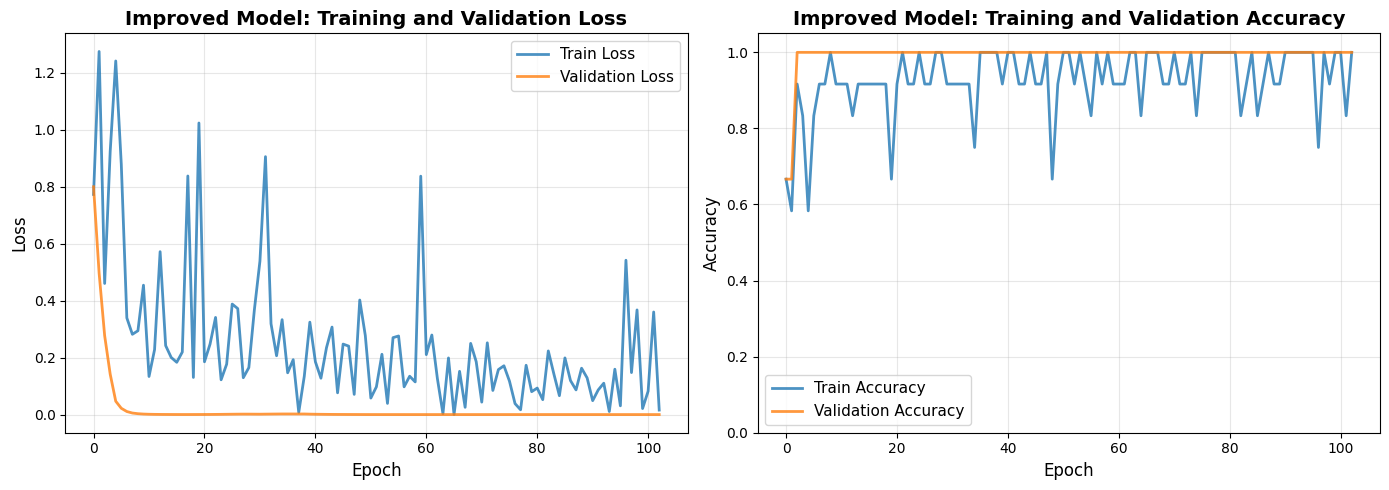

In [20]:
# Plot improved training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses_v2, label='Train Loss', linewidth=2, alpha=0.8)
axes[0].plot(val_losses_v2, label='Validation Loss', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Improved Model: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs_v2, label='Train Accuracy', linewidth=2, alpha=0.8)
axes[1].plot(val_accs_v2, label='Validation Accuracy', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Improved Model: Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [21]:
# Test the improved model
model_v2.eval()
with torch.no_grad():
    output_v2 = model_v2(features_v2, adj_v2)

# Test accuracy
pred_test_v2 = output_v2[idx_test_v2].max(1)[1]
acc_test_v2 = pred_test_v2.eq(labels_v2[idx_test_v2]).sum().item() / idx_test_v2.size(0)

# Training accuracy
pred_train_v2 = output_v2[idx_train_v2].max(1)[1]
acc_train_final = pred_train_v2.eq(labels_v2[idx_train_v2]).sum().item() / idx_train_v2.size(0)

# Validation accuracy
pred_val_v2 = output_v2[idx_val_v2].max(1)[1]
acc_val_final = pred_val_v2.eq(labels_v2[idx_val_v2]).sum().item() / idx_val_v2.size(0)

print("\n" + "=" * 70)
print("IMPROVED MODEL - FINAL RESULTS")
print("=" * 70)
print(f"Training Accuracy:   {acc_train_final*100:.2f}% ({pred_train_v2.eq(labels_v2[idx_train_v2]).sum().item()}/{len(idx_train_v2)} correct)")
print(f"Validation Accuracy: {acc_val_final*100:.2f}% ({pred_val_v2.eq(labels_v2[idx_val_v2]).sum().item()}/{len(idx_val_v2)} correct)")
print(f"Test Accuracy:       {acc_test_v2*100:.2f}% ({pred_test_v2.eq(labels_v2[idx_test_v2]).sum().item()}/{len(idx_test_v2)} correct)")
print("=" * 70)

print(f"\n📊 Detailed Predictions for All Nodes:")
print("-" * 70)

pred_all_v2 = output_v2.max(1)[1]
correct_by_class = {0: [0, 0], 1: [0, 0], 2: [0, 0]}  # [correct, total]

for i in range(num_nodes_v2):
    true_label = labels_v2[i].item()
    pred_label = pred_all_v2[i].item()
    is_correct = true_label == pred_label
    status = "✓" if is_correct else "✗"
    
    if i in idx_train_v2:
        node_type = "Train"
    elif i in idx_val_v2:
        node_type = "Val  "
    else:
        node_type = "Test "
    
    correct_by_class[true_label][1] += 1
    if is_correct:
        correct_by_class[true_label][0] += 1
    
    print(f"Node {i:2d} ({node_type}) | True: {true_label} | Predicted: {pred_label} | {status}")

print("-" * 70)
print("Per-Class Accuracy:")
for c in range(num_classes_v2):
    correct = correct_by_class[c][0]
    total = correct_by_class[c][1]
    acc = correct / total * 100 if total > 0 else 0
    print(f"  Class {c}: {acc:.1f}% ({correct}/{total} correct)")
print("=" * 70)


IMPROVED MODEL - FINAL RESULTS
Training Accuracy:   100.00% (12/12 correct)
Validation Accuracy: 100.00% (3/3 correct)
Test Accuracy:       100.00% (5/5 correct)

📊 Detailed Predictions for All Nodes:
----------------------------------------------------------------------
Node  0 (Train) | True: 0 | Predicted: 0 | ✓
Node  1 (Train) | True: 0 | Predicted: 0 | ✓
Node  2 (Train) | True: 0 | Predicted: 0 | ✓
Node  3 (Train) | True: 0 | Predicted: 0 | ✓
Node  4 (Val  ) | True: 0 | Predicted: 0 | ✓
Node  5 (Test ) | True: 0 | Predicted: 0 | ✓
Node  6 (Test ) | True: 0 | Predicted: 0 | ✓
Node  7 (Train) | True: 1 | Predicted: 1 | ✓
Node  8 (Train) | True: 1 | Predicted: 1 | ✓
Node  9 (Train) | True: 1 | Predicted: 1 | ✓
Node 10 (Train) | True: 1 | Predicted: 1 | ✓
Node 11 (Val  ) | True: 1 | Predicted: 1 | ✓
Node 12 (Test ) | True: 1 | Predicted: 1 | ✓
Node 13 (Test ) | True: 1 | Predicted: 1 | ✓
Node 14 (Train) | True: 2 | Predicted: 2 | ✓
Node 15 (Train) | True: 2 | Predicted: 2 | ✓
Node 16

In [22]:
# Compare Original vs Improved Model
print("\n" + "=" * 70)
print("COMPARISON: ORIGINAL vs IMPROVED MODEL")
print("=" * 70)
print(f"{'Metric':<25} | {'Original':<15} | {'Improved':<15} | {'Change':<15}")
print("-" * 70)
print(f"{'Number of Nodes':<25} | {num_nodes:<15} | {num_nodes_v2:<15} | +{num_nodes_v2-num_nodes}")
print(f"{'Input Features':<25} | {num_features:<15} | {num_features_v2:<15} | +{num_features_v2-num_features}")
print(f"{'Hidden Units/Head':<25} | {nhid:<15} | {nhid_v2:<15} | +{nhid_v2-nhid}")
print(f"{'Attention Heads':<25} | {nheads:<15} | {nheads_v2:<15} | +{nheads_v2-nheads}")
print(f"{'Dropout Rate':<25} | {dropout:<15.1f} | {dropout_v2:<15.1f} | {dropout_v2-dropout:+.1f}")
print(f"{'Training Nodes':<25} | {len(idx_train):<15} | {len(idx_train_v2):<15} | +{len(idx_train_v2)-len(idx_train)}")
print(f"{'Total Parameters':<25} | {total_params:<15,} | {total_params_v2:<15,} | +{total_params_v2-total_params:,}")
print("-" * 70)
print(f"{'Test Accuracy':<25} | {acc_test*100:<14.1f}% | {acc_test_v2*100:<14.1f}% | {(acc_test_v2-acc_test)*100:+.1f}%")
print("=" * 70)

# Calculate improvement
improvement = (acc_test_v2 - acc_test) * 100
if improvement > 0:
    print(f"\n✅ Test accuracy improved by {improvement:.1f} percentage points!")
elif improvement < 0:
    print(f"\n⚠️ Test accuracy decreased by {abs(improvement):.1f} percentage points.")
else:
    print(f"\n➡️ Test accuracy remained the same.")


COMPARISON: ORIGINAL vs IMPROVED MODEL
Metric                    | Original        | Improved        | Change         
----------------------------------------------------------------------
Number of Nodes           | 7               | 20              | +13
Input Features            | 5               | 10              | +5
Hidden Units/Head         | 8               | 16              | +8
Attention Heads           | 4               | 6               | +2
Dropout Rate              | 0.6             | 0.3             | -0.3
Training Nodes            | 4               | 12              | +8
Total Parameters          | 326             | 1,446           | +1,120
----------------------------------------------------------------------
Test Accuracy             | 0.0           % | 100.0         % | +100.0%

✅ Test accuracy improved by 100.0 percentage points!
